<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Performance-comparison" data-toc-modified-id="Performance-comparison-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Performance comparison</a></span></li><li><span><a href="#Ensemble" data-toc-modified-id="Ensemble-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Ensemble</a></span></li></ul></div>

In [95]:
import pdb 
import glob
import copy
import math
import pickle
import csv
import boto3

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
 
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.model_selection import train_test_split, \
#     StratifiedShuffleSplit, cross_val_score, StratifiedKFold, \
#     GridSearchCV, RandomizedSearchCV

# from sklearn.decomposition import PCA
# from sklearn.linear_model import LogisticRegression, \
#     LogisticRegressionCV, SGDClassifier
# from sklearn.svm import SVC, LinearSVC
# from sklearn.ensemble import RandomForestClassifier, \
#     ExtraTreesClassifier, VotingClassifier

from sklearn.metrics import confusion_matrix, classification_report, \
    precision_recall_curve, average_precision_score, f1_score, \
    roc_curve, auc, roc_auc_score, make_scorer,\
    accuracy_score, balanced_accuracy_score

from sklearn.externals import joblib
# from sklearn.utils import resample
# from sklearn.utils.fixes import signature

# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 

# # Load line profiler
# %load_ext line_profiler

# Adjust number of CPU cores to use
# n_jobs=2

In this concluding notebook, will first compare the performance of all estimators, And then we will combine their predictions into an ensemble classifier.

## Performance comparison

Let's start by visualizing the performance of each classifier.  To do so, we first need to load and combine the average precision scores from both notebooks (the one run locally in the one run on AWS).

In [85]:
# Load average precision scores 
ap_1 = joblib.load('saved_models/average_precisions.joblib')
ap_2 = joblib.load('saved_models/average_precisions-AWS.joblib')
# Combine scores and convert to Series and sort
ap = pd.Series(  
        {**ap_1, **ap_2}) \
        .sort_values(ascending=False)

Now we are ready to plot the average precision score for each model:

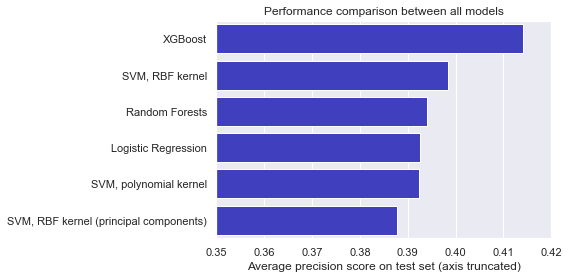

In [86]:
# Plot performance
model_names = ['XGBoost', 'SVM, RBF kernel',
               'Random Forests', 'Logistic Regression', 
               'SVM, polynomial kernel',
               'SVM, RBF kernel (principal components)']
sns.barplot(x=ap.values, y=model_names,
            orient='h',
            color='blue', saturation=.5)
plt.xlim(0.35,0.42)
plt.title('Performance comparison between all models')
plt.xlabel('Average precision score on test set (axis truncated)')
plt.show();

As we already knew, XGBoost far outperformed the other models.  Note that the x-axis does not started zero, because this would give the misleading picture that the models perform all about equally. Even though XGBoost outperforms the other models only by 0.02, this is actually a substantial improvement, because getting the last boost in accuracy gets increasingly hard. The reason we know that this improvement is indeed noteworthy is that it is large compared to the variance in scores we observe between the rest of the models.

This visualization also allows a more nuanced comparison of the other learners. To start with, we see that using principal components did not pay of. Apparently, the information lost by reducing the dimensionality of the feature space more than outweighed the information gained by being able to use a bigger sample size. So let's focus on the other models estimated on the full data set from now on. 

Another observation is that the SVM with RBF kernel does perform substantially better than logistic regression, random forests, and the SVM with polynomial kernel.  It is reassuring that it was worth it to go to so great length (e.g., using AWS) to make training this model feasible. 

By contrast, using the polynomial kernel does not provide a similar increase in performance.  This is probably due to the fact that polynomials often behave erratically far away from the mean. Nevertheless, it likely was still worth it to train an expensive model such as this, because it gives us another set of predictions to use in the ensemble. The same can be said about the model trained on the principal components, because the key to deriving benefit from an ensemble is to get predictions that are not to correlated between the different models. 

## Ensemble

In [12]:
# Load true target variable for test set
y_test = joblib.load('data_processed/y_test.joblib')

In [7]:
! ls ./predictions_test

y_lr_2.joblib
y_lr_hp.joblib
y_proba_xgb.joblib
y_rf_2.joblib
y_rf_hp.joblib
y_score_lr_hp.joblib
y_score_rf_hp.joblib
y_score_svm_lin_hp.joblib
y_score_svm_rbf_gs_1.joblib
y_score_xgb.joblib
y_svm_lin_hp.joblib
y_svm_poly_2.joblib
y_svm_rbf_2.joblib
y_svm_rbf_gs_1.joblib
y_svm_rbf_pc_2.joblib
y_xgb_2.joblib


In [87]:
# Load predictions and combine them into a data frame
model_names = ['rf', 'lr', 'xgb', 
               'svm_rbf', 'svm_rbf_pc', 'svm_poly']
              
y_preds = pd.DataFrame(
            {model_name: joblib.load(
                f'predictions_test/y_{model_name}_2.joblib')
                    for model_name in model_names})

In [88]:
# Compute average prediction for each opservation
y_pred_mean = y_preds.mean(axis=1)

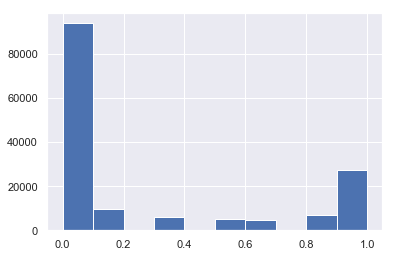

In [89]:
y_pred_mean.hist()

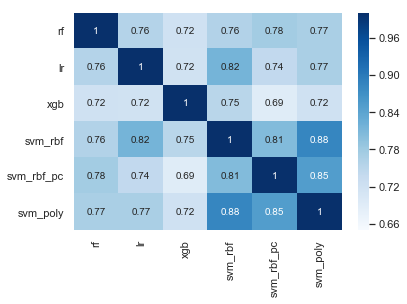

In [97]:
# Correlation between models
corr = y_preds.corr()
sns.heatmap(corr,
           annot=True,
           cmap='Blues',
           vmin=0.65)

In [96]:
# AP (lower than individual models because we dont have enough threshholds)
average_precision_score(y_test, 
                        y_pred_mean)

0.33374228805349926